# 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [ ]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
import typing
%matplotlib inline

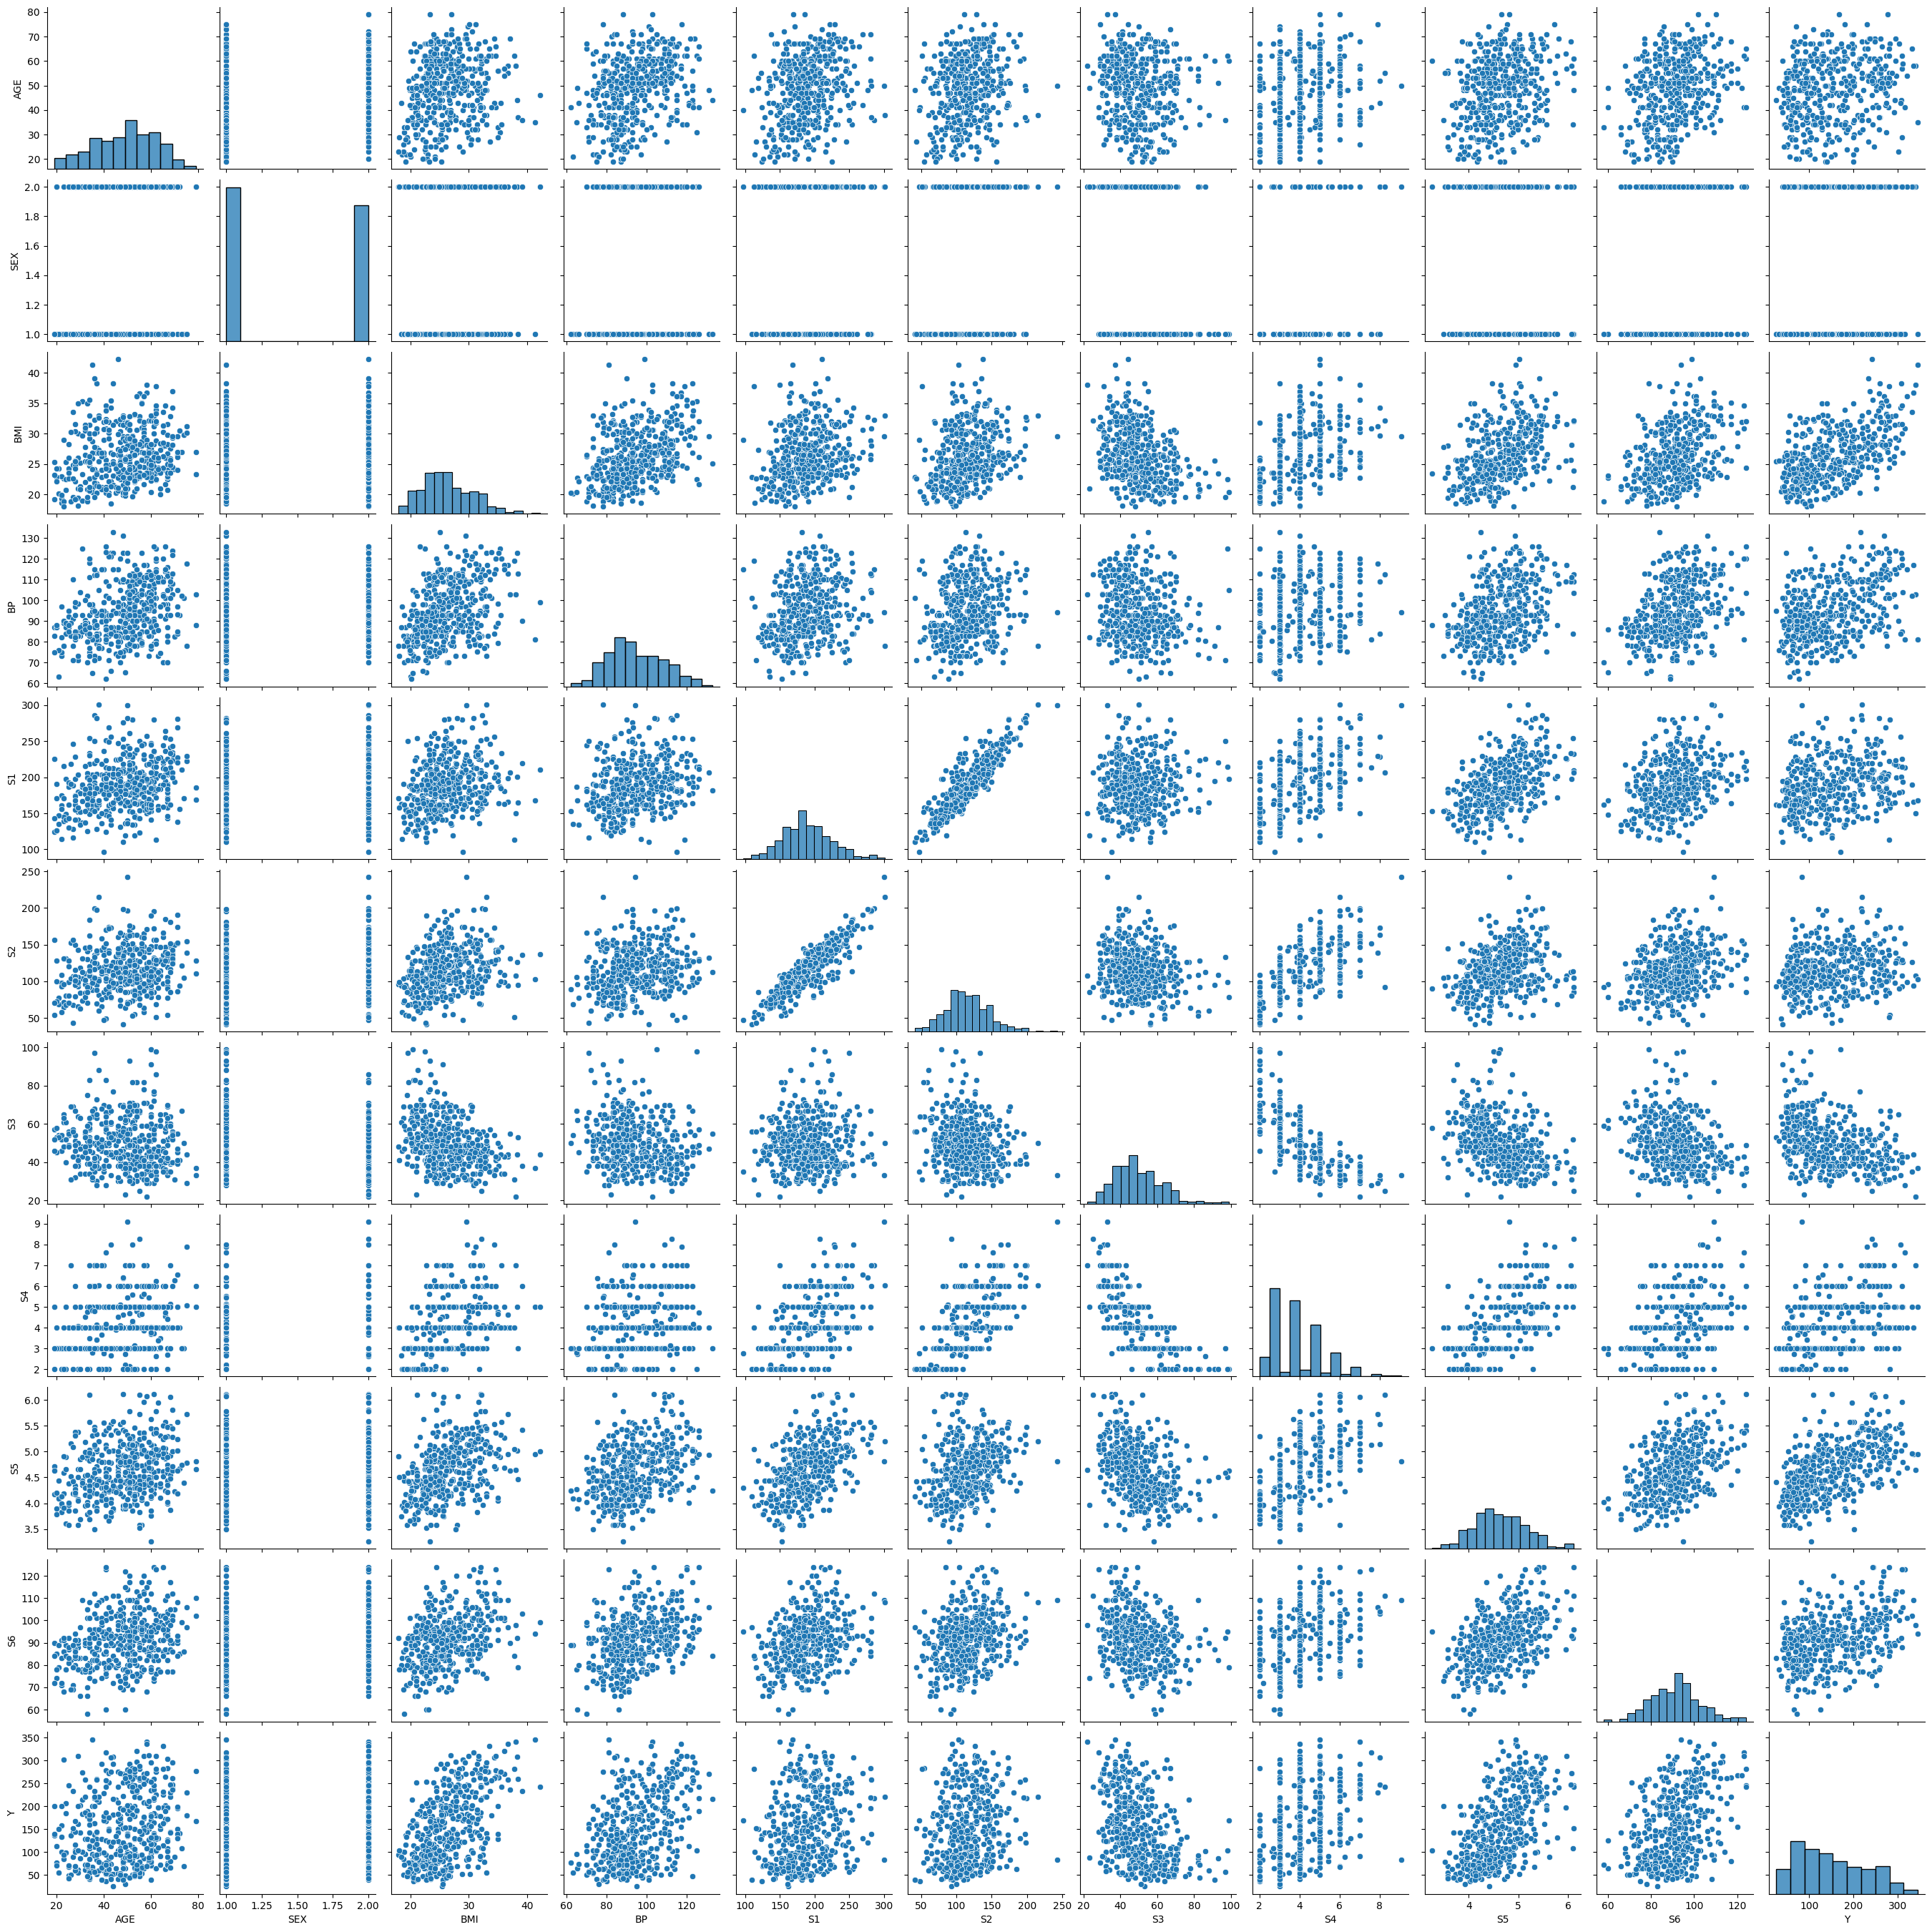

In [ ]:
diabetes_db = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    sep='\t', header=0)
sn.pairplot(diabetes_db)

In [ ]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42)

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(Y_train.values).float().reshape(-1, 1)
y_test = torch.from_numpy(Y_test.values).float().reshape(-1, 1)

We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

## Question 1
Complete the method and normalize `x_train, x_test`. [2 marks]

In [ ]:
"""
PROGRAMMING NOTE:
In the below function definition, we are enforcing the datatypes for the
function's parameters & return value. For the argument parameters, we enforce
type for each argument as:

... argName: argType

For return value, we enforce type as:`

... -> returnType
"""

def norm_set(x:torch.Tensor,mu:torch.Tensor,sigma:torch.Tensor)->torch.tensor:
  return (x-mu)/sigma

**IMPLEMENTATION NOTE**: **Shape of the tensor & what it means to normalize it**:<br>When we convert a dataset (with each columns representing the values of a particular field across observations and rows representing a particular observations) into a tensor of two dimensions, we get an array of arrays wherein each sub-array is a row and the ordered set of the nth element of every sub-array is the column. Thus. to normalize the data of the tensor, we must normalize each column separately, using the particular column's mean and standard deviation. We can do this using the following functions...
<br><br>
`torch.sub` **&** `torch.div` **functions**:<br>Given a tensor A of m rows and n columns, and given another tensor of 1 row and n columns, `tensor.sub(A, B)` subtracts the element of B in column 1 from every element of A in column 1, the element of B in column 2 from every element of A in column 2, etc. I.e. we can do column-wise subtraction for the columns of A using the values of B. Similarly for `tensor.div(A, B)`, except here the operation is division instead of subtraction. These very operations can be achieved with regular operators as well, so we just do that.

In [ ]:
# Calling the function to obtain normalized data
norm_x_train = norm_set(x_train, torch.mean(x_train, 0), torch.std(x_train, 0))

"""
PROGRAMMING NOTE:
The torch.mean & torch.std functions return Tensor objects.
------------------------
torch.mean(x, 0):
- Gives the means of each column of x
- Alternative: x.mean(axis=0) (given that x is a tensor oject)

torch.std(x, 0):
- Gives the stardard deviations of each column of x
- Alternative: x.std(axis=0) (given that x is a tensor oject)
------------------------
For getting the same but row-wise, use 1 instead of 0; we don't want this now.
"""

# Comparing samples of the normalized & original tensors for reference
print("\nOriginal values:\n", x_train[:3, :3])
print("Normalized values:\n", norm_x_train[:3, :3])


Original values:
 tensor([[68.0000,  2.0000, 27.5000],
        [46.0000,  2.0000, 24.7000],
        [50.0000,  1.0000, 31.0000]])
Normalized values:
 tensor([[ 1.4962,  1.0599,  0.2196],
        [-0.2285,  1.0599, -0.4188],
        [ 0.0851, -0.9408,  1.0175]])


In [ ]:
mu = {"x_train": torch.mean(x_train, 0), "y_train": torch.mean(y_train)}
sigma = {"x_train": torch.std(x_train, 0), "y_train": torch.std(y_train)}

x_train = norm_set(x_train, mu["x_train"], sigma["x_train"])
x_test = norm_set(x_test, mu["x_train"], sigma["x_train"])

**CONCEPTUAL NOTE**: **The purpose of normalisation**:<br>Normalisation is essentially transforming the distribution within which the sample values of a variable seem to lie (based on the sample mean & standard deviation, i.e. the sample's centrality & spread) to a distribution with mean 0 and standard deviation 1.
<br><br>
This is useful when dealing with mutliple feature/predictor variables that each seems to lie in a different distribution (i.e. having a different range, centrality, spread, etc.). In such a case, the weights that would be obtained for variables with smaller ranges and spread (smaller in terms of magnitude) would be weighted less than ones with larger ranges and spread, whether or not the variables with the smaller magnitudes of range and spread are more or as significant to the output as the larger ones. Normalisation helps eliminate this scale factor by bringing all variables down to the same distribution (hence the same approximate scale), with the same magnitudes of range and spread. With normalisation, the proportion of change with respect to the output is given more importance than the magnitude, offering a clearer insight into the effect of a variable on the output regardless (_since proportions give the rates of change whereas magnitudes give the scale of the change, which could be more due to the scale of measurement units; small changes in rates of change could be scaled up to be large numbers, obscuring the fact that the change was relatively insignificant when considered in context_).
<br><br>
Since we have multiple predictor variables but only a single target variable, we are normalising the predictors alone. We could normalise the target variable, but it is not necessary; we only need to find the relationship between the predictors and target, essentially mapping values from the distribution of the predictor variables to the distribution of the target variable, and the scale and shift (i.e. shift in mean) of this mapping is easy to account for when training the model; the scale and shift can be accounted for with the scale of the weights (multiplicative values) & the bias (an additive value) in the model's function.

**TECHNICAL NOTE**:<br>We are bringing every observation to the same distribution as the one we calculate for the training data, since the training data should be the only reference for a model's parameters. Thus, we normalize the testing data as well as any possible observation we need to predict for using the means and standard deviations calculated for the training data.

# 1.1 Linear Regression

We will build the linear regression model in pytorch using a custom layer. We define the hypothesis function as $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

## Question 2
Fill in the forward method of the linear regression class. [2 marks]

In [ ]:
# Add a feature for bias
"""
PROGRAMMING NOTE: torch.cat
dim=1 specifies that the new tensor must be concatenated as a column.
dim=0 specifies that the new tensor must be concatenated as a row.
Naturally:
- If to be concatenated as a column, number of rows should match.
- If to be concatenated as a row, number of columns should match.
"""
# Adding bias feature as the first column
x_train = torch.cat([torch.ones(x_train.shape[0], 1), x_train], dim=1)
x_test = torch.cat([torch.ones(x_test.shape[0], 1), x_test], dim=1)

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features),
                               requires_grad=False)
    """
    NOTE: The `requires_grad` parameter of any `torch.nn.Parameter` object
    specifies whether autograd should be used or not for any given function of
    this tensor.
    """

  def forward(self, x):
    y = x @ self.weight.T # @ denotes matrix multiplication
    # NOTE: y should be a column vector with the same number of rows as x
    return y

**IMPLEMENTATION NOTE**: **Order of operations**:<br>The standard formulation for a linear regression function is given as $f(x)=w^{T}x$, where $w$ is a column vector of weights and $x$ is a matrix wherein each row vector contains the different observations of a single variable. However, the way we have defined weights in our implementation is as a row vector of weights, while the way the $x$ values are defined mean that each row is a single observation of the different variables; here, each column is contains the different observations of a single variable. Now, the goal of multiplying weights with the feature/predictor values (i.e. $x$ values) is the ensure that each variable is weighted by its respective weight; all observations of a single variable must get the same weight, and all variables in a single observation must get their respective weights. To achieve the same purpose in our case, we have rearranged the terms in the matrix multiplication.

---

As we need to account for the bias, we add a column of ones to the `x_data`

In [ ]:
## Test the custom layer
model = LinearRegression(x_train.shape[1])
# NOTE: Number of features = Number of columns in x_train

prediction = model.forward(x_train)
print(prediction.shape) # the output should be Nx1

torch.Size([353, 1])


**PROGRAMMING NOTE**: **Callable objects?**:<br>
We can call any object that has an implementation of the `__call__()` method in its class definition. The class `nn.Module` has this implementation, which means so does any subclass of it (such as the above defined class `LinearRegression`). Furthermore, it seems that the `__call__()` method of the `nn.Module` class is defined so that it uses the `forward` method defined in any subclass. Hence, if we have an object `model` of class `LinearRegression`, we can call the forward method as `model(x)` instead of `model.forward(x)`. However, for conceptual clarity, we will call the forward method as `model.forward(x)` only.

**REFERENCE**: https://www.pythonforbeginners.com/basics/callable-objects-in-python

---

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

## Question 3
Fill in the method to calculate the squared error of for any set of labels $y$ and predictions. [2 marks]

In [ ]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor):
  return (((y_true - y_pred)**2).sum()/y_true.shape[0]).item()
  # .item method converts a single-valued tensor into a numeric value ex. float

In [ ]:
print(mean_squared_error(prediction, y_train))

29711.322265625


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

## Question 4
In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights. We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [ ]:
def gradient_descent_step(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
                          y_pred: torch.Tensor, lr: float) -> None:
  # NOTE: lr ==> learning rate, i.e. alpha

  # Initialising the weights
  weight = model.weight
  M, N = x.shape
  """
  # POSSIBLE IMPLEMENTATION WITH LOOPS
  # (for conceptual clarity)
  for i in range(N): # For N columns (i.e. N features)
    for j in range(M): # For M rows (i.e. M observations)
      weight[0, i] += -(2*lr*x[j, i]*(y_pred[j] - y[j])/M)[0]
  """

  # IMPLEMENTATION WITH TENSOR OPERATIONS
  # (this is much faster than loops)
  weight[0] += -2*lr*(x * (y_pred-y)).sum(axis=0)/M
  # axis=0 indicates column-wise summing

  model.weight = nn.Parameter(weight, requires_grad=False)

**PROGRAMMING NOTE 1**: **Usage of** `*` **operation on tensors**:<br>Multiplying A and B using `*` has the same effect as using the function `torch.multiply`, i.e. `A*B = torch.multiply(A, B)`. In the case where A is of dimension PxQ and B is of dimension Px1 (i.e. B is a column vector with the same number of rows as A), then `A*B` leads to a new tensor of dimension PxQ where every row i of `A*B` is the scalar multiple of the row i of A with the element i of B. Note that this operation is commutative, which means `A*B` = `B*A`.

**PROGRAMMING NOTE 2**: **The tensor operations involved**:<br>Given that `x` is a tensor of dimension $M \times N$, we have that:

- `y` has dimension $M \times 1$
- `y_pred` has dimension $M \times 1$
- Hence, `y_pred - y` also has dimension $M \times 1$

Now, we want to multiply each observation of a particular feature in `x` (_given by a particular column's values_) to the corresponding value of the marginal error (_i.e. predicted y-value minus actual y-value_). In other words, we want to multiply element i of column c in `x` with the element i in `y_pred - y`, for all i and c. Thus, ultimately, we want to multiply each row i in `x` with the element i in `y_pred - y`, for all i. Thus, we can safely apply `(y_pred - y) * x` and expect this result.

**TECHNICAL NOTE**: **Choosing the right** $\alpha$ **value**:<br>The gradient calculated in gradient descent is that of the cost function. The $\alpha$ value or the learning rate determines whether the gradient descent being calculated converges or diverges and at what rate, which means it determines whether the weights -- and consequently the cost calculated -- convege or not. If $\alpha$ is too large, the gradient descent's magnitude will tend toward $\infty$ even as the algorithm tries to correct its descent's direction (i.e. sign); since the gradient calculated in gradient descent is that of the cost function itself, the cost also tends to $\infty$, making learning impossible. If $\alpha$ is too small, the gradient descent (thus the cost) would converge but at a much slower rate, reducing learning speed. In our case, $\alpha=0.1$ is a suitable order of magnitude for the learning rate; one order of magnitude higher and the cost diverges, any orders of magnitude lower and the learning speed only worsens (for at least $100$ iterations of the gradient descent step). Note that this value was found through trial and error.

---

Testing the gradient descent function...

In [ ]:
# Testing the gradient descent step function:
gradient_descent_step(model, x_train, y_train, prediction, 0.1)
prediction = model.forward(x_train) # Getting updated model's predictions
cost = mean_squared_error(prediction, y_train) # Getting updated cost
print(cost)

18911.36328125


Performing gradient descent iteratively...

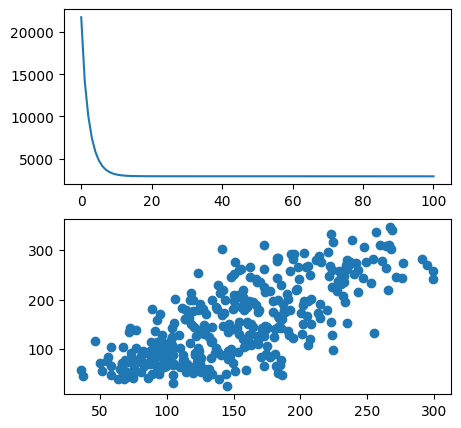


MODEL WEIGHTS
w0	:  153.736526 --> bias
w1	:  1.939769 --> AGE
w2	: -11.449014 --> SEX
w3	:  26.303600 --> BMI
w4	:  16.631128 --> BP
w5	: -9.944833 --> S1
w6	: -2.269463 --> S2
w7	: -7.669748 --> S3
w8	:  8.223666 --> S4
w9	:  22.000544 --> S5
w10	:  2.605969 --> S6

COSTS
Minimum	: 2890.245849609375
Final	: 2890.245849609375


In [ ]:
# INITIALISING THE GRADIENT DESCENT PROCESS
# Initializing the model:
model = LinearRegression(x_train.shape[1])
# List to store costs generated over descent:
costList = []
# Choosing the learning rate:
alpha = 0.1
#====================================
# THE GRADIENT DESCENT STEP LOOP
# We will run this loop for 100 iterations
for i in range(101):
  # Doing a gradient descent & getting updated model's predictions:
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
  prediction = model.forward(x_train)
  # Getting & appending updated cost:
  cost = mean_squared_error(prediction, y_train)
  costList.append(cost)
#====================================
# PLOTTING COSTS OBTAINED IN THE COURSE OF THE GRADIENT DESCENT
fig, ax = plt.subplots(2)
fig.set_size_inches(5, 5)
ax[0].plot(list(range(i+1)), costList)
ax[1].scatter(prediction, y_train)
plt.show()
#====================================
# DISPLAYING WEIGHTS & COSTS
# Displaying model weights with the associated column names
weight = [w.item() for w in list(model.weight[0])]
column = ["bias"] + list(diabetes_db.columns)[:-1] # Excluding the Y column
print("\nMODEL WEIGHTS")
for i,w in enumerate(weight):
  sign = {True: "-", False: " "}[w < 0] # For enabling neat display of signs
  print(f"w{i}\t: {sign}{abs(w):.6f} --> {column[i]}")

# Displaying minimum cost & final cost:
print("\nCOSTS")
print(f"Minimum\t: {min(costList)}")
print(f"Final\t: {costList[-1]}")

## Question 5
<font color="maroon">What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels? What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

**CONCLUSIONS**: **Part 1**<br>Judging by the weights alone, we can draw the following conclusions:

1. The magnitude of a variable's impact on the predicted target value
  - _This indicates the strength of the relationship between the given predictor and target variables_
2. Whether the impact is negative (i.e. higher the predictor value, lower the predicted target value, all else equal) or positive (i.e. higher the predictor value, higher the predicted target value, all else equal)
  - _This indicates the kind of relationship (proportional or inverse) between the given predictor and target variables_

Hence, we see that BMI (body mass index), BP (blood pressure) and S5 are the biggest factors contributing to the predicted blood sugar level, with sex, S1, S3 and S4 also having a moderate to high impact. Furthermore, we see that the impact of BMI, BP and S5 is positive, while the impact of sex (discussed later below), S1 and S3 is negative. Looking at the less significantly weighted variables, we see that age and S6 has a relatively small and positive impact, while S2 have a low and negative impact.

**CONCLUSIONS**: **Part 2**<br>
BMI has a relatively high positive weight, indicating that there is a strong positive relationship between blood sugar levels and BMI; the higher the BMI, the more the blood sugar levels tend to be (with significant correlation). This matches common knowledge, since people have BMI's due to having higher body weight relative to their height (such is the calculation of BMI), which tends to be a result of the higher consumption energy-dense foods such as carbohydrates (which break down to sugar) and sugars.

Gender (given as "SEX" in the data) has a relatively high negative weight (_high in terms of absolute magnitude_). To interpret this, we must first note the way gender is encoded in the data; 2 for female, 1 for male (with the normalised values being 1.0599 and -0.9408 respectively). The high negative weight implies that the higher the value of the sex "SEX", the lower the blood sugar level tends to be (with significant correlation). This indicates that being a female (i.e. being given a higher value in this encoding) has a negative impact on the predicted blood sugar level, tending to lower it. Reviewing some research on gender differences in blood sugar (or glucose) levels, we see that women have a higher risk of hypoglycaemia (low blood sugar) than men and tend to have a lower blood sugar level than men on average. This matches the weightage given to the variable "SEX" in our linear regression model.
<br><br>
**REFERENCES**:

- "Gender differences in foods uptakes, glycemic index, BMI, and various plasma parameters between young men and women in Japan"
  - Link: https://www.oatext.com/Gender-differences-in-foods-uptakes-glycemic-index-BMI-and-various-plasma-parameters-between-young-men-and-women-in-Japan.php
  - Quote: "_Basic levels of blood glucose levels are lower in women than men_."
- "The effects of baseline characteristics, glycaemia treatment approach, and glycated haemoglobin concentration on the risk of severe hypoglycaemia: post hoc epidemiological analysis of the ACCORD study"
  - Link: https://www.bmj.com/content/340/bmj.b5444.long
  - Quote: "_We found significantly increased risks for hypoglycaemia among women_"

---

Estimating blood sugar levels for:<br>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [ ]:
# Function to normalize new data & get the result
"""
As our model was trained on a normalised distrribution, it can predict reliably
only for features lying in the same distribution; thus, we normalise the given
feature values (x-values) using the mean & standard deviation of the training
set.

NOTE: we normalised only for x-values, not y-values (i.e. target values).
"""
def predict(model, x):
  x = norm_set(x, mu["x_train"], sigma["x_train"])
  # Adding the bias after normalisation
  x = torch.cat([torch.tensor([1]), x], dim=0)
  y = model.forward(x).item()
  return y

In [ ]:
x1 = torch.tensor([25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68])
x2 = torch.tensor([50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 123])
prediction1 = predict(model, x1)
prediction2 = predict(model, x2)
print("ESTIMATED BLOOD SUGAR LEVELS")
print(f"Person 1: {prediction1:.5f}")
print(f"Person 2: {prediction2:.5f}")

ESTIMATED BLOOD SUGAR LEVELS
Person 1: 43.54755
Person 2: 232.10165


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [ ]:
prediction_test = model.forward(x_test)
print(mean_squared_error(prediction_test, y_test))

2885.6298828125


In [ ]:
# Printing the target value's training data's mean & standard deviation
# (for getting an idea about the shift & scale of the target values)
print(mu["y_train"].item())
print(sigma["y_train"].item())

153.73654174804688
78.06190490722656


**CONCLUSIONS**:<br>We see that the mean squared errors on the test set $\approx 2885.609$ is very close to the mean squared errors on the training set $\approx 2890.339$. Given the scale of the variation in the target variable's values in the training set (_standard deviation_ $\approx 78.062$), the difference between the mean squared errors of the training and testing sets is insignificant ($~0.06\%$ _of the standard deviation of the target variable's values in the training set_).
<br><br>
This indicates that the model is not overfitted, i.e. the model's weights are not fine-tuned to the training set and are generalised enough to make predictions for new data with reasonable accuracy. An underfitted model is indicated by the mean squared errors being high in any set, training or testing. An overfitted model is indicated by the mean squared error being low in the training set but high in the testing set.

## Question 6
<font color="maroon">Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

In [ ]:
# FUNCTION TO PERFORM GRADIENT DESCENT LOOP
# (... to perform gradient descent steps iteratively)
def gradient_descent_loop(x, y, alpha, nIterations, getAllCosts=False):
  # NOTE: nIterations ==> Number of loop iterations

  # Initializing the model:
  model = LinearRegression(x.shape[1])
  # The future list of costs obtained:
  costList = []
  #------------------------
  # We will run this loop for `nIterations` iterations
  for i in range(nIterations+1):
    # Doing gradient descent & getting updated model's predictions:
    prediction = model.forward(x)
    gradient_descent_step(model, x, y, prediction, alpha)
    if getAllCosts: costList.append(mean_squared_error(prediction, y))
  #------------------------
  # Returning obtained mean squared error (cost)
  if getAllCosts: return costList
  return mean_squared_error(prediction, y)

Defining the $\alpha$ values in a list...

In [ ]:
alphaList = [0.1**(n) for n in range(-2, 4)]

Obtaining all the cost-related data for training and testing data

In [ ]:
def getCostData(x, y):
  costs, costsPerLoop = [], []
  for alpha in alphaList:
    costs.append(gradient_descent_loop(x, y, alpha, 5))
    costsPerLoop.append(gradient_descent_loop(x, y, alpha, 50, True))
    # NOTE: costsPerLoop is for plotting purposes later
    """
    IMPLEMENTATION NOTE:
    We are running fewer iterations for the numerical data because a few
    iterations is enough to show whether the cost converges or diverges.

    We are running many more iterations for plotting to get smoother cost
    function curves and better portray their convergence or divergence
    graphically.
    """
  return costs, costsPerLoop

# Obtaining the cost-related data
train = getCostData(x_train, y_train)
test = getCostData(x_test, y_test)

Displaying the final costs obtained for both training and testing data for the different $\alpha$ values.

In [ ]:
pd.DataFrame(
    data = {"cost (in training)": train[0], "cost (in testing)": test[0]},
    index = [f"alpha={alpha:.0e}" for alpha in alphaList])

,cost (in training),cost (in testing)
alpha=1e+02,1.760926e+32,7.406606e+31
alpha=1e+01,1.570402e+22,6.665720e+21
alpha=1e+00,4.620044e+11,2.176643e+11
alpha=1e-01,5.562790e+03,5.840854e+03
alpha=1e-02,2.408285e+04,2.204420e+04
alpha=1e-03,2.907237e+04,2.605022e+04


Plotting the cost curves to get a better idea about their convergence or divergence...

In [ ]:
def plot_costs(costs, title):
  plt.figure(figsize=(2, 2))
  plt.plot(range(len(costs)), costs)
  plt.title(title)

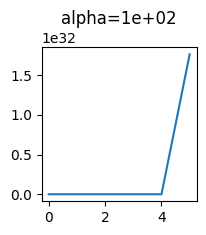

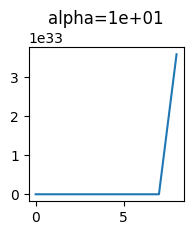

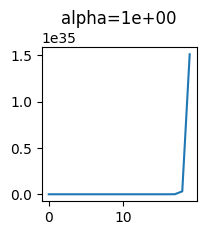

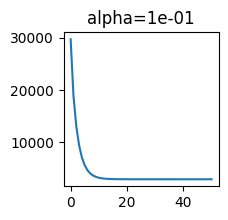

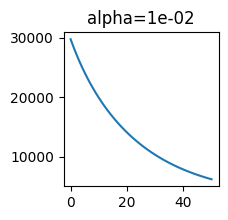

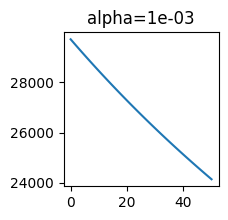

In [ ]:
# Plotting cost data for training
for i, alpha in enumerate(alphaList):
  plot_costs(train[1][i], f"alpha={alpha:.0e}")

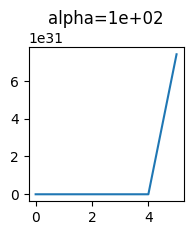

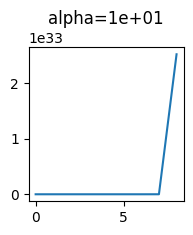

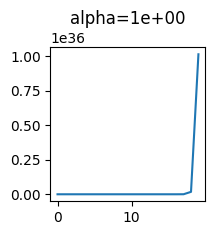

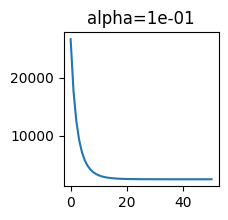

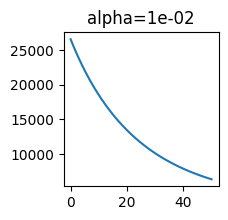

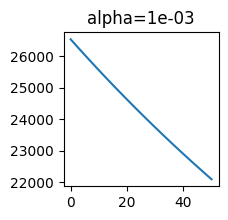

In [ ]:
# Plotting cost data for testing
for i, alpha in enumerate(alphaList):
  plot_costs(test[1][i], f"alpha={alpha:.0e}")

**CONCLUSIONS**:<br>The errors (mean squared errors, which is the cost function in our case) for the training and testing sets changes similarly for both sets, since the fit is well-generalised.
<br><br>
**CONCLUSIONS**:<br>The errors (_mean squared errors between predictions and true values, which is the cost function in our case_) for the training and testing sets change similarly for both sets, since the fit is well-generalised. The $\alpha$ values (_i.e. learning rates used_) determine whether and how fast the errors (_i.e. mean squared errors_) converge or diverge with gradient descent (_note that the gradient being calculated is that of the cost function with respect to the weight vector, i.e. for the the mean squared errors with respect to the weight vector_). From the above result, it is clear that at the magnitude level $10^{0}$ (i.e. $1$) is the lowest magnitude level at which the errors diverge. From level $10^{-1}$ onwards, the errors only converge. We also see that for higher $\alpha$ values at and above the magnitude level $10^{0}$, the error diverges faster the higher $\alpha$ is, whereas for lower $\alpha$ values at and below the magnitude level $10^{-1}$, the error converges slower the lower $\alpha$ is.

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

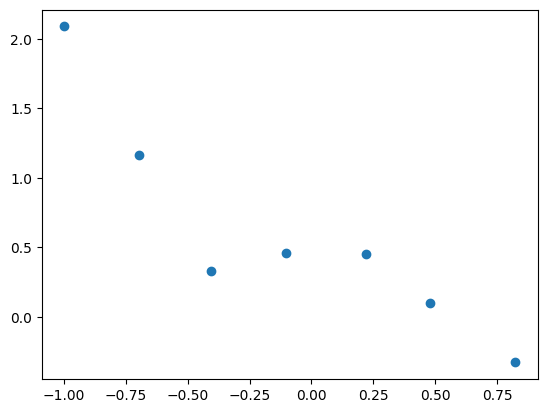

In [ ]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236,
                  0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013,
                  0.44808, 0.10013, -0.32952]).reshape(-1, 1)
# This reshaping ensures y is a column vector instead of a row vector
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

---

**NOTE**: Here, $m$ is the number of observations (i.e. number of rows in `x`), while $n$ is the number predictors/features (i.e. number of rows in `x`).

---

Adjust variable `x` to include the higher order polynomials

In [ ]:
# Adding higher order terms:
x = torch.tensor([list(x**i) for i in range(1, 6)]).T
# We transponse as we want each x^i to be a separate column not a separate row

# Adding bias field as the first column:
x = torch.cat([torch.ones(x.shape[0], 1), x], dim=1)

# Displaying x:
print(x)

tensor([[ 1.0000e+00, -9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01,
         -9.8845e-01],
        [ 1.0000e+00, -6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01,
         -1.6302e-01],
        [ 1.0000e+00, -4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02,
         -1.0726e-02],
        [ 1.0000e+00, -1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04,
         -1.1237e-05],
        [ 1.0000e+00,  2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,
          5.1818e-04],
        [ 1.0000e+00,  4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,
          2.4803e-02],
        [ 1.0000e+00,  8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,
          3.7595e-01]])


## Question 7
Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]


Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [ ]:
# NEW MEAN SQUARED ERROR FUNCTION DEFINITION
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor,
                       lam: float, theta: torch.tensor):
  m = y_true.shape[0] # Number of observations
  cost = (((y_pred - y_true)**2).sum()/m).item()
  cost += (lam*(theta[0]**2).sum()).item()
  return cost/2*m

In [ ]:
# NEW GRADIENT DESCENT STEP FUNCTION DEFINITION
def gradient_descent_step(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
                          y_pred: torch.Tensor, lr: float, lam: float) -> None:
  """
  lr ==> learning rate (chosen constant)
  lam ==> lambda (chosen constant)
  """
  weight = model.weight
  m = x.shape[0] # Number of observations
  BTW = torch.tensor([weight[0][0]]) # Bias term weights
  # NOTE: We do not want BTW to have 0 dimensions, so we do the above
  NBTW = weight[0][1:] # Non-bias term weights

  NBTW *= (1 - lr*lam/m)
  NBTW -= lr*(x[:, 1:] * (y_pred - y)).sum(axis=0)/m
  # x[:, 1:] excludes the first column of x, with contains x^0 (for bias)
  # NBTW should be a row tensor of n-1 values (n ==> number of columns in x)

  BTW -= lr*(x[:, 0] * (y_pred - y)).sum()/m
  # x[:, 0] selects the first column of x, with contains bias
  # BTW should be a single-valued row tensor

  # Mergin NBTW & BTW to get the overall weights
  weight[0] = torch.cat([BTW, NBTW], dim=0)

  # Updating the model
  model.weight = nn.Parameter(weight, requires_grad=False)

In [ ]:
# Initializing a new regression model
model = LinearRegression(x.shape[1])
# NOTE: Number of features = Number of columns in x

# Obtaining mean squared error for predicted values
prediction = model.forward(x)
mean_squared_error(y, prediction, 1, model.weight)

3.1786368787288666

## Question 8
<font color="maroon">First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

In [ ]:
# NEW GRADIENT DESCENT STEP LOOP FUNCTION DEFINITION
# (... to perform gradient descent steps iteratively)
def gradient_descent_loop(x, y, alpha, lam, nIterations,
                          getModel=False, getCosts=False):
  # NOTE: nIterations ==> Number of loop iterations

  # Initializing the model:
  model = LinearRegression(x.shape[1])
  # The future list of costs obtained:
  costList = []
  #------------------------
  # We will run this loop for `nIterations` iterations
  for i in range(nIterations+1):
    # Doing gradient descent & getting updated model's predictions:
    prediction = model.forward(x)
    gradient_descent_step(model, x, y, prediction, alpha, lam)
    if getCosts:
      costList.append(mean_squared_error(y, prediction, lam, model.weight))
  #------------------------
  # Returning obtained mean squared error (cost)
  if getModel: return model
  if getCosts: return costList
  return mean_squared_error(prediction, y, lam, model.weight)

### Optimizing $\alpha$

In [ ]:
# Example of an alpha leading to diverging costs
# (... useful for explaining the alpha-finding algorithm)
print(f"For alpha={2}, cost={gradient_descent_loop(x, y, 2, 0, 2)}")

For alpha=2, cost=47177.31005859375


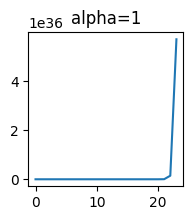

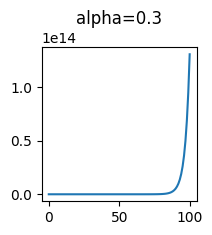

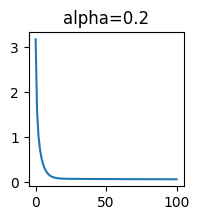

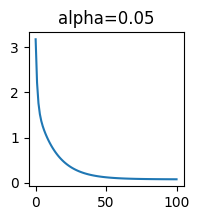

In [ ]:
# Plotting cost function curve for different alpha values
# (... useful for explaining the alpha-finding algorithm)
alphaList = [1, 0.3, 0.2, 0.05]
for alpha in alphaList:
  costsGenerated = gradient_descent_loop(x, y, alpha, 0, 100, False, True)
  plot_costs(costsGenerated, f"alpha={alpha}")

In [ ]:
# Finding the alpha that leads to minimum cost
# (for 100 gradient step iterations)

"""
This algorithm will obtain the fastest converging alpha value
for N gradient descent step iterations (here, N is fixed as 100).
"""

# NOTE 1: We are fixing lambda as 0 for now
# NOTE 2: alpha must be positive, since it is the cost convergence factor.

# Small helper function
def switch(a, b): return b, a

# Initializing lower & upper bounds of optimal alpha & their costs
"""
Here, we are using three pieces of prior knowledge
1. alpha must be above zero
2. alpha = 2 leads to diverging cost
3. If an alpha leads to a cost exceeding 3.1786, the cost diverges
"""
L, U = 0, 2
costL = gradient_descent_loop(x, y, L, 0, 100)
costU = gradient_descent_loop(x, y, U, 0, 100)

# Doing the search
for i in range(50):
  if costU < costL:
    costL, costU = switch(costL, costU)
    L, U = switch(L, U)

  cost = gradient_descent_loop(x, y, (L + U)/2, 0, 100)
  if cost <= 3.1786 and cost < costL: L, costL = (L + U)/2, cost
  else: U, costU = (L + U)/2, cost

# Displaying the upper & lower bounds for best alpha (with upper & lower costs)
print(f"Best alpha value lies in [{L:.6f}, {U:.6f}]")
print(f"Lowerst cost lies in [{costL:.6f}, {costU:.6f}]")

Best alpha value lies in [0.268557, 0.268557]
Lowerst cost lies in [0.064086, 0.064086]


**TECHNICAL NOTE**: **Justifying the above algorithm:**<br>Assumption on the cost function:

- The cost function is an exponential curve of the form $e^{f(x)}$, where $f(x)$ is a function of the number of gradient descent steps $x$
- Thus, the cost curve is either monotonically increasing (in case of a diverging curve, where $f(x)$ is positive) or monotonically decreasing (in case of a converging curve, where $f(x)$ is negative)

These observations were made based on the plots of cost function curves for different $\alpha$ values (note again that $\alpha$ is the factor that determines the rate of convergence or divergence of the cost function). Based on these assumptions, consider the following...
<br><br>
Given the fact that our initial cost (calculated when testing the new mean squared function) is a little over $3.1786$, any $\alpha$ that does not lead to a converging cost will present cost values larger than $3.1786.5$ after enough (_more than 5_) gradient descent steps (_and will diverge to infinity as the number of iterations of the gradient descent step increases_). Thus, any $\alpha$ value leading to costs less than or equal to $3.1786$ after the end of a sufficient number of iterations will certainly converge.
<br><br>
Now, if the cost converges for $\alpha=k$, then it must converge for all $\alpha \leq k$ and for any $\alpha < k$. Furthermore, it is logical to conclude that given $N$ gradient step iterations, if both $\alpha_1$ and $\alpha_2$ converge and $\alpha_1$ leads to a lower cost than $\alpha_2$, then for $N$ iterations, $\alpha$ converges more toward the minimum cost (which is asymptotic in our cost function).
<br><br>
Let us define the optimal $\alpha$ value as the one that converges the most in $N$ gradient step iterations. Thus, if we have that optimal $\alpha$ value's lower bound is $L$ and the upper bound is $U$, then, if some $\alpha$ value between $L$ and $U$, say $\frac{L+U}{2}$ leads to converging cost (i.e. cost less than or equal to $3.1786$), then any $\alpha$ value between $L$ and $\frac{L+U}{2}$ is suboptimal (i.e. converges more slowly). Thus, the optimal $\alpha$ must lie in the range $[\frac{L+U}{2}, U]$, which means it is now valid to make the lower bound $\frac{L+U}{2}$.
<br><br>
On the other hand, if $\frac{L+U}{2}$ does not lead to a lower or faster converging cost than $L$, then the optimal $\alpha$ must lie in the range $[L, \frac{L+U}{2}]$, which means it is now valid to make the upper bound $\frac{L+U}{2}$.
<br><br>
Thus, the algorithm followed by the above code will indefinitely narrow down the bounds of the optimal $\alpha$ value (unless an exact value is found, in which case the lower and upper bounds will become equal).

---


**SIDE NOTE 1**: **Degree of convergence for different numbers of iterations**:<br>$N$ gradient steps have always been specified when talking about optimal $\alpha$ values, and this is due to the following fact observed about different $\alpha$ values. Some $\alpha$ values converge more than others in fewer iterations, but if the iterations are increased, these same $\alpha$ values may converge lesser than other $\alpha$ values it previously outperformed. For example, $\alpha=0.25$ converges more than $\alpha=0.27$ for $10$ gradient step iterations, but $\alpha=0.27$ converges more than $\alpha=0.25$ for $100$ iterations. For this reason, the "optimal" $\alpha$ was defined with respect to the number of gradient descent step iterations.
<br><br>
**SIDE NOTE 2**:<br>Based on different observations with different $\alpha$ values and number of gradient step iterations (the results are not presented in this document), a conjecture can be made (for the given cost function) that if both $\alpha_1$ and $\alpha_2$ lead to converging costs, and if $\alpha_1>\alpha_2$, then for a sufficiently high (but finite) number of gradient step iterations, $\alpha_1$ will always converge more than $\alpha_2$.

### Experimenting with different $\lambda$

In [ ]:
# Generating data for different lambda values
"""
NOTE:
lambda must be positive, since it is the factor of the extra cost added to
the cost function that penalizes high weight magnitudes that tend to overfit
the model.
"""
lamList, predictionList = [50, 10, 5, 1, 0.5, 0.1, 0], []
for lam in lamList:
  # Training the model with the given lambda value
  model = gradient_descent_loop(x, y, 0.2685, lam, 100, True)
  # Getting & saving predictions
  prediction = model.forward(x)
  predictionList.append([p.item() for p in prediction])

Plotting the hypothesis curves for different $\lambda$ values...

In [ ]:
# Function to plot a given set of predictions against true values
def plot_hypothesis(prediction, title, size=(3,3)):
  plt.figure(figsize=size)
  # Scatter plot to see the original data
  plt.scatter(x[:, 1], y, c='red', marker='x', label='Ground truth')
  # NOTE: x[:, 0] gives the 1st column, which consists of the original x values
  plt.plot(x[:, 1], prediction, c='blue', marker='o', label='Prediction')
  plt.title(title), plt.xlabel('x'), plt.ylabel('y=f(x)')

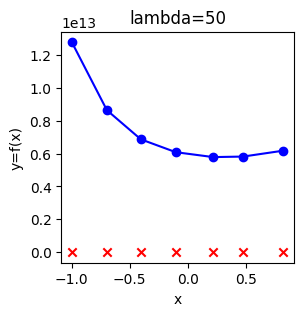

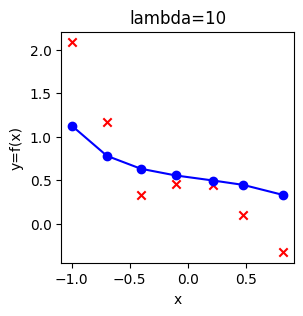

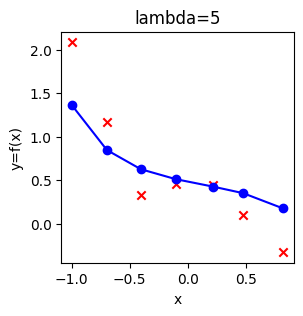

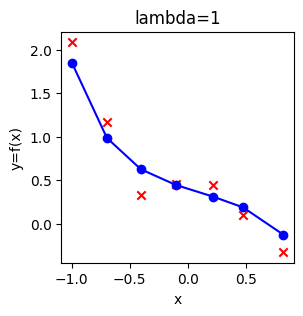

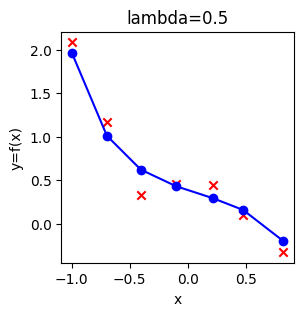

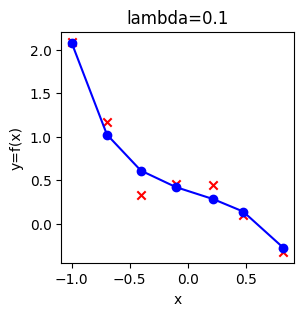

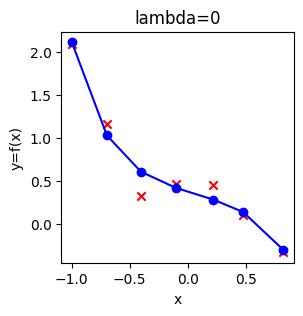

In [ ]:
# Creating a plot per lambda value
for i in range(len(lamList)):
  # Using the `plot_costs` function defined before
  plot_hypothesis(predictionList[i], f"lambda={lamList[i]}")

**CONCLUSIONS**: **The effect of different** $\lambda$ **values**:<br>In general, the higher the $\lambda$ value (i.e. the regularization parameter), the less exact or accurate the fit of the predictions is with respect to the training data. We see that up to a point, the higher the $\lambda$ value, the flatter and further away on average from the true values the hypothesis curve gets, reflecting the fact that all the errors (cost function values) are pushed to high values due to the regularization term. Beyond a point, i.e. for sufficiently high $\lambda$ values, the fit becomes completely inaccurate and even changes its shape from a flat curve vaguely passing through the points to a curve away from any point in the same direction.

**CONCEPTUAL NOTE**: **Finding the right $\lambda$ value**:<br>$\lambda$, as the regularization parameter, is the value that controls the level of overfitting, i.e. the difference between the costs (mean squared errors in our case) of the training and testing sets. In this context, the testing set is the validation set. In our case, there is no validation set obtainable, hence we cannot determine the $\lambda$ value required to correct for overfitting (if at all). Hence, we shall set the $\lambda$ value to $0$ for the upcoming code.

## Final model evaluation

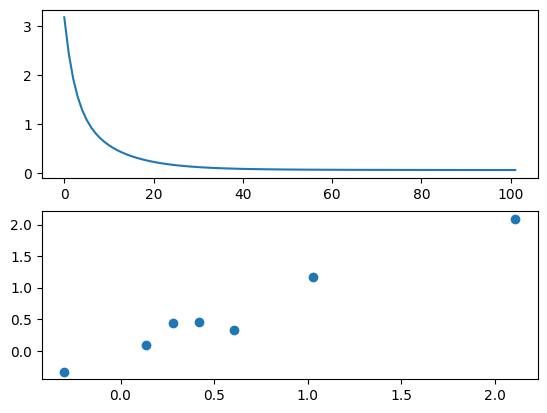


MODEL WEIGHTS
theta 0	:  0.373595 --> x_0 (bias)
theta 1	: -0.414131 --> x^1
theta 2	:  0.108378 --> x^2
theta 3	: -0.570773 --> x^3
theta 4	:  0.187764 --> x^4
theta 5	: -0.466443 --> x^5

COSTS
Minimum	: 0.06401411350816488
Final	: 0.06401411350816488


In [ ]:
# INITIALISING THE NEW GRADIENT DESCENT PROCESS
# Initializing the model:
model = LinearRegression(x.shape[1])
# Obtaining the first set of predictions:
prediction = model.forward(x)
# List to store costs generated over descent:
# (starting with the initial cost to begin comparing with)
costList = [mean_squared_error(prediction, y, lam, model.weight)]
# Choosing the learning rate & lambda:
alpha = 0.2685 # Obtained earlier
lam = 0 # Default
#====================================
# THE GRADIENT DESCENT LOOP
# We will run this loop either until 100 iterations
for i in range(101):
  # Doing a gradient descent & getting updated model's predictions:
  gradient_descent_step(model, x, y, prediction, alpha, lam)
  prediction = model.forward(x)
  # Getting & appending updated cost:
  cost = mean_squared_error(prediction, y, lam, model.weight)
  costList.append(cost)
#====================================
# PLOTTING COSTS OBTAINED IN THE COURSE OF THE GRADIENT DESCENT
fig, ax = plt.subplots(2)
ax[0].plot(list(range(i+2)), costList)
ax[1].scatter(prediction, y)
plt.show()
#====================================
# DISPLAYING WEIGHTS & COSTS
# Displaying model weights with the associated column names
weight = [w.item() for w in list(model.weight[0])]
column = ["x_0 (bias)"] + [f"x^{i+1}" for i in range(5)]
print("\nMODEL WEIGHTS")
for i,w in enumerate(weight):
  sign = {True: "-", False: " "}[w < 0] # For enabling neat display of signs
  print(f"theta {i}\t: {sign}{abs(w):.6f} --> {column[i]}")

# Displaying minimum cost & final cost:
print("\nCOSTS")
print(f"Minimum\t: {min(costList)}")
print(f"Final\t: {costList[-1]}")

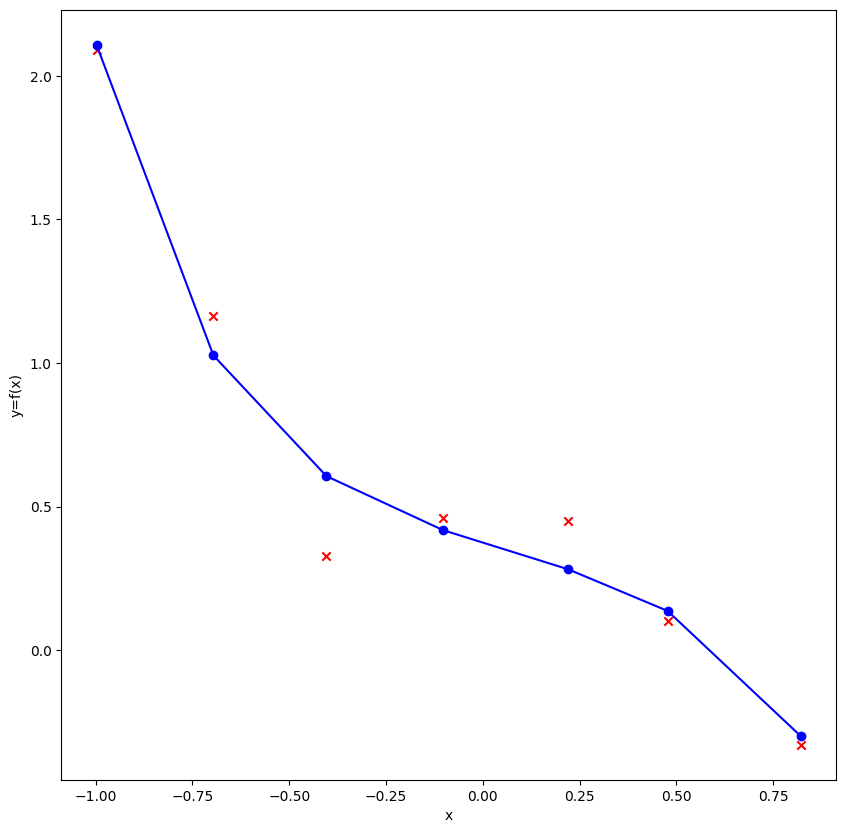

In [ ]:
# Plotting the final hypothesis curve
plot_hypothesis(model.forward(x), "", (10, 10))